Gliding sports of all sorts, such as hang gliding, paragliding, and flying sailplanes are akin to traditional sailboating in comparison to modern powered ships; they're a beautiful blend of science/engineering, yet they inherently require a little art and finesse in order to excel at them.

Top paragliders from all over the world often compete in unpowered flight, soaring hundreds of miles over the course of just a few days. How is this possible? With mastery of the winds, overall weather, and a little bit of luck from atmospheric instability allows paragliders to obtain great amounts of lift from rising columns of relatively warm air, known as thermals. If you've ever seen soaring birds circling in the sky, chances are they are riding mother nature's elevator; a thermal. 

Although there are other types of lift, such as ridge compression that paragliders can take advantage of to stay airborne for longer, the purpose of undertaking this project is to better understand the science behind thermals, specifically where and when paraglider pilots find them, and look for any common trends in flight patterns. 

Experienced paragliders are likely more familiar with local site micrometeorology and can navigate the space easier than a novice. But with the goal in mind of using data to infer where any thermal hotspots may exist, along with where glider pilots don't fly, we can provide a safer flight experience for all paragliding pilots and potentially keep pilots in the air for longer.

Flight data is aggregated from www.xcontest.org in the form of an IGC file, which is a flight log file formated with text. Throughout this notebook, I will be referencing the documentation found here: https://xp-soaring.github.io/igc_file_format/igc_format_2008.html in order to generate parsing for the flights.

In [54]:
import pandas as pd
import glob
import re
import numpy as np
import pathlib
import time
import sqlite3
import folium 
from folium import Map
from folium.plugins import HeatMap
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

In [12]:
#Let's Take a Look at an IGC File to see its contents
test_file_dir = 'S:/Data/Paragliding_Data/all_flights/2022-07-22-XCT-VSH-16.igc'
igc_file = open(test_file_dir)
with igc_file as read_obj:
    head = [next(igc_file) for x in range(30)]
for line in head:
    line = line.replace('\n','')
    print(line)

AXCT18c359dc8568e12c
HFFTYFRTYPE:samsung SM-G991U1 12 Client:xctrack FlightId:15f0f55c-99d5-42ed-9092-4b94465c5cbe
HFRFWFIRMWAREVERSION:0.9.7.6 LIVE:00f373a5d08968632036ad54f11236aa3b738e92
HFPLTPILOTINCHARGE:Vinay Shah
HOSITSite:Wonderland
HSCCLCOMPETITION CLASS:FAI-3 (PG)
HFGTYGLIDERTYPE:GIN GLIDERS Fuse 3
HODTM100GPSDATUM:WGS-84
HFALPALTPRESSURE:ISA
HFALG:GEO
I023636LAD3737LOD
HFDTEDATE:220722,00
LXCTDEVICE eyJkZXZpY2UiOnsiY3B1QUJJIjoiYXJtNjQtdjhhIiwic2RrIjozMSwiZGlzcGxhe
LXCTDEVICE SI6eyJ3IjoxMDgwLCJoIjoyMTc2LCJtbSI6MTguODk3NjM4fSwiZmluZ2VycHJpbn
LXCTDEVICE QiOiJzYW1zdW5nL28xcXVldy9vMXE6MTIvU1AxQS4yMTA4MTIuMDE2L0c5OTFVMVV
LXCTDEVICE FUzVDVkY1OnVzZXIvcmVsZWFzZS1rZXlzIiwibW9kZWwiOiJTTS1HOTkxVTEiLCJk
LXCTDEVICE ZXZRdWV1ZUJ1aWxkIjoiZjIzYWFmMTQ4ZTVmYTBjYzBhMDUwM2VhODE2NTk3YzliY
LXCTDEVICE zQ4MDgwZCIsInByb2R1Y3QiOiJvMXF1ZXciLCJhbmRyb2lkSWQiOiIxOGMzNTlkYz
LXCTDEVICE g1NjhlMTJjIiwibWFudWZhY3R1cmVyIjoic2Ftc3VuZyIsImRldmljZVN0cmluZyI
LXCTDEVICE 6InNhbXN1bmcgU00tRzk5MVUxIDEyIiwiYnVpbGRJZCI6Il

In [132]:
#Let's get an idea of how many lines we need to parse through
with open(test_file_dir,'r') as flight:
    line_count = 0
    for line in flight:
        line_count += 1

line_count

13770

In [131]:
#We can parse through the lines of the file and extract the useful data that we want into a DataFrame
#I've added notes below for some other summary functions to understand what we are trying to do.
#I will be improving this parsing function in the future

def igc_file_reader(f):
    df = pd.DataFrame()
    with open(f,'r') as flight:
        site = 'Null'
        date = 'Null'
        pilot = 'Null'
        glider = 'Null'
        tzoffset = 0
        for line in flight:
            if (line.startswith('B')): 
                df = df.append({
                    'timestamp' : int(line[1:7]),
                    'latitude'  : str(line[7:15]),
                    'longitude' : str(line[15:24]),
                    'alt_pressure'  : str(line[25:30]),
                    'alt_gps'   : str(line[30:35]),
                    }, ignore_index=True) 
            elif 'DATE' in line:
                date = str(re.search(r'\d{6}', line).group(0))
            elif 'HFDTE' in line:
                date = str(line[5:11])   
            elif 'PILOT' in line:
                 pilot = str(re.search(r'(?<=:)[^\]]+', line).group(0))
            elif 'TZN' in line:
                 tzoffset = str(re.search(r'(?<=:)[^\]]+', line).group(0))  
            elif 'Site' in line:
                 site = str(line.split(":")[1:][0])
            elif 'SITE' in line:
                 site = str(line.split(":")[1:][0])
            elif 'GLIDER' in line:
                 glider = str(line.split(":")[1:][0])
    df['start_location'] = site
    df['date'] = date 
    df['pilot'] = pilot 
    df['flight_id'] = pathlib.PurePath(f).stem
    df['tzoffset'] = tzoffset #record timezone offset, if any are located in the .igc file. Most default to UTC time, some local, and some with offset. More to come on this one.
    df['glider'] = glider
    #Grab The date. We need to add the year into this then convert to datetime
    if df['date'].unique() != 'Null':
        date_fill = df['date'].unique()
        date_fill = date_fill[0]
        df['date'] = date_fill[:-2] + '20' + date_fill[-2:] 
        df['date'] = pd.to_datetime(df['date'],format = '%d%m%Y',dayfirst=True,errors='coerce')

    #Convert the timestamps to datetime and grab the interval. Some logs are in 30 second intervals which won't be useful for analysis
    df['interval'] = (pd.to_datetime(df['timestamp'],format = '%H%M%S',errors='coerce').shift(-1) - pd.to_datetime(df['timestamp'],format = '%H%M%S',errors='coerce'))
    df['interval'] = df['interval'].apply(lambda x: x.total_seconds())
    df['timestamp'] = pd.to_datetime(df['timestamp'],format = '%H%M%S',errors='coerce').dt.strftime('%H:%M:%S')

    #Time Zone offset logic TBD later use
    # df['timestamp'] = df['timestamp'].apply(lambda x: x - pd.Timedelta(7,'h'))
    # df['timestamp'] = df['timestamp'].apply(lambda x: x.time())
    # df['timestamp'] = df['timestamp'] - datetime.timedelta(hours=7)
    # df['timestamp'] = df['timestamp'] - pd.to_timedelta(df['timestamp'].dt.days, unit='d')

    #Add all of the other details that we'll need for analysis
    #We are going to use moving average crossover to find our peaks and troughs of lift to identify thermal source location.
    df['alt_pressure'] = df['alt_pressure'].astype(int) #Convert altitude back to integer from string
    short_window = 90 #Moving average windows, more on these later
    long_window = 360
    criteria_window = 360
    df['thermal'] = 0
    df['sma_90'] = df['alt_pressure'].rolling(short_window).mean()
    df['sma_360'] = df['alt_pressure'].rolling(long_window).mean()
    df['thermal'][criteria_window:] = np.where(df['sma_90'][criteria_window:] > df['sma_360'][criteria_window:], 1, 0) 
    df['thermal'] = df['thermal'].shift(-120) #Discussed below. Shifting crossover points back to identify thermal start point.
    df['thermal_start'] = df['thermal'].diff() #Identifies the moment of lift and moment of sink
    df['vario'] = df['alt_pressure'].diff() #Variometer readout, which will be lift per interval
    df = df.replace('\n','', regex=True) #Get rid of any spacing issues caused in parsing to indicate new line breaks
    #Finding and notating first thermal and start and finish
    if df['thermal_start'].to_list().index(1.0) > 0:
        ft_idx = df['thermal_start'].to_list().index(1.0) #Finds first occurance of a thermal to mark the first thermal found in the flight. Needs to be refined. More on that below.
    df['first_thermal'] = 0
    df['first_thermal'][ft_idx] = 1
    df['start'] = 0
    df['end'] = 0
    end_idx = len(df)-1 #End of flight
    df['start'][0] = 1 #Start of flight
    df['end'][end_idx] = 1
    df['dd_latitude'] = ''  #Placeholder for later parsing
    df['dd_longitude'] = '' #Placeholder for later parsing
    return df

In [101]:
#Let's run the function on our test flight and make sure that the data is imported properly.
test_flight = igc_file_reader(test_file_dir)
test_flight

,timestamp,latitude,longitude,alt_pressure,alt_gps,start_location,date,pilot,flight_id,tzoffset,...,thermal,sma_90,sma_360,thermal_start,vario,first_thermal,start,end,dd_latitude,dd_longitude
0,16:46:47,4003374N,10517989W,1913,01911,Wonderland,2022-07-22,Vinay Shah,2022-07-22-XCT-VSH-16,0,...,0.0,NaN,NaN,NaN,NaN,0,1,0,,
1,16:46:48,4003374N,10517989W,1913,01910,Wonderland,2022-07-22,Vinay Shah,2022-07-22-XCT-VSH-16,0,...,0.0,NaN,NaN,0.0,0.0,0,0,0,,
2,16:46:49,4003374N,10517989W,1913,01910,Wonderland,2022-07-22,Vinay Shah,2022-07-22-XCT-VSH-16,0,...,0.0,NaN,NaN,0.0,0.0,0,0,0,,
3,16:46:50,4003374N,10517989W,1913,01909,Wonderland,2022-07-22,Vinay Shah,2022-07-22-XCT-VSH-16,0,...,0.0,NaN,NaN,0.0,0.0,0,0,0,,
4,16:46:51,4003374N,10517989W,1913,01910,Wonderland,2022-07-22,Vinay Shah,2022-07-22-XCT-VSH-16,0,...,0.0,NaN,NaN,0.0,0.0,0,0,0,,
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13735,20:35:45,3950855N,10514157W,1858,01847,Wonderland,2022-07-22,Vinay Shah,2022-07-22-XCT-VSH-16,0,...,NaN,1897.377778,2055.797222,NaN,0.0,0,0,0,,
13736,20:35:46,3950855N,10514157W,1858,01847,Wonderland,2022-07-22,Vinay Shah,2022-07-22-XCT-VSH-16,0,...,NaN,1896.344444,2054.658333,NaN,0.0,0,0,0,,
13737,20:35:47,3950855N,10514157W,1858,01846,Wonderland,2022-07-22,Vinay Shah,2022-07-22-XCT-VSH-16,0,...,NaN,1895.333333,2053.522222,NaN,0.0,0,0,0,,
13738,20:35:48,3950855N,10514157W,1858,01846,Wonderland,2022-07-22,Vinay Shah,2022-07-22-XCT-VSH-16,0,...,NaN,1894.344444,2052.388889,NaN,0.0,0,0,0,,


##Make change to igc_file_decoder. Thermals not detected in some flights, Johannes for example because altitude from pressure readings are 0, and GPS is recorded altitude. Build more robust logic around that.

##Refine Moving Averages to detect first thermal initially. Moving averages likely won't work well considering that lift must be found within the first 2 mins of flight

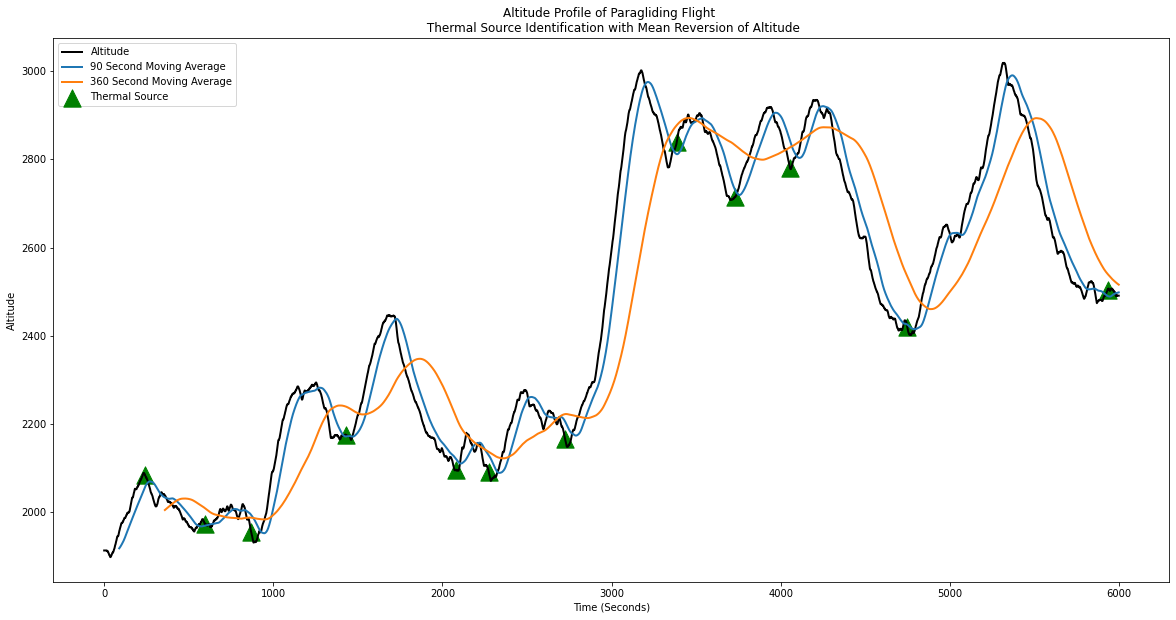

In [102]:
#Plotting Data to check troughs as thermal source location
signal = test_flight['alt_pressure'][:6000].loc[test_flight['thermal_start'] == 1]
fig=plt.figure(figsize=(20,10))
ax1 = fig.add_subplot(ylabel='Altitude',xlabel='Time (Seconds)',title='Altitude Profile of Paragliding Flight \n Thermal Source Identification with Mean Reversion of Altitude')
test_flight['alt_pressure'][:6000].plot(ax=ax1,color='black',lw=2, label= 'Altitude')
test_flight['sma_90'][:6000].plot(ax=ax1,lw=2,label='90 Second Moving Average')
test_flight['sma_360'][:6000].plot(ax=ax1,lw=2,label='360 Second Moving Average')
ax1.scatter(signal.index,signal,marker='^',s = 300,c='g',alpha=1.0,label='Thermal Source')
plt.legend(loc = 'upper left')
plt.show()


In [103]:

#Degrees Minutes Seconds Conversion. This is necessary for formatting if exporting, but we 
#Need to do this to establish the proper breaks in the string for converison to decimal degrees in the next step as OpenStreetMaps and Folium run off of Decimal Degrees
test_flight['latitude'] = test_flight['latitude'].str[:2]+'\u00b0'+ test_flight['latitude'].str[2:4] +'.'+ test_flight['latitude'].str[4:6] + test_flight['latitude'].str[6:7] +'\'' + test_flight['latitude'].str[7:8]
test_flight['longitude'] = test_flight['longitude'].str[:3]+'\u00b0'+ test_flight['longitude'].str[3:5] +'.' + test_flight['longitude'].str[5:7] + test_flight['longitude'].str[7:8]+ '\'' + test_flight['longitude'].str[8:9]

test_flight.head()

,timestamp,latitude,longitude,alt_pressure,alt_gps,start_location,date,pilot,flight_id,tzoffset,...,thermal,sma_90,sma_360,thermal_start,vario,first_thermal,start,end,dd_latitude,dd_longitude
0,16:46:47,40°03.374'N,105°17.989'W,1913,01911,Wonderland,2022-07-22,Vinay Shah,2022-07-22-XCT-VSH-16,0,...,0.0,NaN,NaN,NaN,NaN,0,1,0,,
1,16:46:48,40°03.374'N,105°17.989'W,1913,01910,Wonderland,2022-07-22,Vinay Shah,2022-07-22-XCT-VSH-16,0,...,0.0,NaN,NaN,0.0,0.0,0,0,0,,
2,16:46:49,40°03.374'N,105°17.989'W,1913,01910,Wonderland,2022-07-22,Vinay Shah,2022-07-22-XCT-VSH-16,0,...,0.0,NaN,NaN,0.0,0.0,0,0,0,,
3,16:46:50,40°03.374'N,105°17.989'W,1913,01909,Wonderland,2022-07-22,Vinay Shah,2022-07-22-XCT-VSH-16,0,...,0.0,NaN,NaN,0.0,0.0,0,0,0,,
4,16:46:51,40°03.374'N,105°17.989'W,1913,01910,Wonderland,2022-07-22,Vinay Shah,2022-07-22-XCT-VSH-16,0,...,0.0,NaN,NaN,0.0,0.0,0,0,0,,


In [104]:
#DMS2DD Degrees Minutes Seconds to Decimal Degrees Conversion

#Latitude
for index, row in test_flight.iterrows():
        deg, minutes, direction =  re.split('[°\'"]', str(test_flight['latitude'][index]))
        var1 = (float(deg) + float(minutes)/60)
        var2 = -1 if direction in ['W', 'S'] else 1
        test_flight['dd_latitude'][index] = var1 * var2


#Longitude
for index, row in test_flight.iterrows():
        deg, minutes, direction =  re.split('[°\'"]',str(test_flight['longitude'][index]))
        var1 = (float(deg) + float(minutes)/60)
        var2 = -1 if direction in ['W', 'S'] else 1
        test_flight['dd_longitude'][index] = var1 * var2

While we have thermal source location located in the thermal_start column, I have also designated a column that tracks the entire period of lift in the thermal for displaying on the heatmap, with the column simply titled "thermal" for heatmapping in Folium which I will demonstrate below. The "thermal_start" column in a single data point, derived from the green triangles in the graph above, intended for many flights to be overlaid together. 

However, in order for a flight at the Boulder,CO/Wonderland site to progress beyond 2-5 minutes, significant lift must found within the first couple of minutes of flight, in which we will need to narrow our techinque and scope in .igc file parsing in order to detect and highlight, then overlay many flights into our heatmap using the "thermal_start" data point due to lagging moving average reversions used in this study not being precise enough to detect initial lift.

In [125]:
#Plotting with Folium. Zoom in to see the flight tracks while the pilot is in the thermal!
#We can see in this flight that the pilot traveled quite a distance; over 50 kilometers.

thermals = test_flight.loc[(test_flight['thermal'] == 1)]

lat = thermals['dd_latitude']
lng = thermals['dd_longitude']

for_map = Map(location=[39.8431, -105.250815], zoom_start=10,tiles='Stamen Terrain')
north_launch = folium.Marker(location=[40.056193, -105.299981],popup='North Launch', icon=folium.Icon(color='gray', icon='asterisk')).add_to(for_map)
south_launch = folium.Marker(location=[40.048091, -105.299936],popup='South Launch', icon=folium.Icon(color='gray', icon='asterisk')).add_to(for_map)
hm_wide = HeatMap(
    list(zip(lat,lng)),
    min_opacity=0.2,
    radius=18, 
    blur=8, 
    max_zoom=1,
)
for_map.add_child(hm_wide)

In [ ]:
#I'll insert this flight into the database on my local machine for later retrieval after parsing. 

########################
#### Insert via SQL ####
########################
db = r'S:\Databases\main_db.db'
table = 'paragliding_flights_boulderco'

#Print to let user know it started
print("Starting Data Insert...")
#Create connection to database
try:
    conn = sqlite3.connect(db)
    test_flight.to_sql(table, conn, if_exists="append")
    print('Data Inserted into {}'.format(db))  
except sqlite3.Error as ex:
            print (ex)
finally:
    conn.close()
    print('Closing connection')